# Project: Landslide Exposure of Building Infrastructures in Portland, OR 

### Clean version 
Daniel Acosta, 2021   


## Background
Based on the quantitative landslide risk equation, which is defined as risk as a function of annual probability of landslide (hazard), the spatial and spatial-time probability of a landslide impacting a building (runout and exposure), and the probability of injury or death from a given impact by a landslide (vulnerability). In this sense, a landslide exposure is defined as the analysis of elements at risk of being prone to a hazardous zone. The elements at risk refer to building footprints that match specific susceptibility classes.

Given a landslide susceptibility map, often landslide exposure has been measured using land cover maps for further risk assessment. However, a detailed landslide exposure analysis using building footprint maps is scarce. For this reason, this project explores some ways building footprint data can be utilized to assess landslide exposure in Portland, Oregon, with a focus on building infrastructures. Further research can include social and economical features of the building zones.

## Problem Statement
What is the landslide exposure of building infrastructure in the city of Portland, Oregon? The dataset to be used are:

* Landslide Susceptibility maps
* Building Footprint data

## Objective  
* Load raster data of landslide susceptibility (LS) map of Portland, Oregon
* Load the building data of Portland, Oregon
* Load the Portland neighborhood boundaries 
* Compute the LS level for each building
* Compute the landslide exposure as the area of all buildings under different LS levels

## Tools
* GDAL
* Rasterio
* Rasterstats
* NumPy
* Pandas
* Geopandas
* Matplotlib

## Tools

In [1]:
import os
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio as rio
from rasterio import plot, mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
import matplotlib.pyplot as plt
import rasterstats

In [2]:
from osgeo import gdal
import rasterio as rio
import rasterio.plot

In [3]:
%matplotlib inline

### Projection of the project
UTM Zone 10 (EPSG: 32610)

In [4]:
# Define projection:
proj = 'EPSG:32610'

## Part 1: Landside Susceptibility (ls) Raster data
* Load ls using raster basic to open downloaded image from disk
* Read ls as Numpy Array and exploring
* Reproject ls raster to project's projection 

In [5]:
%pwd

'/home/jovyan/landslide_exposure_portland'

In [6]:
# Define path for LS raster data
path_ls = r'project_data/Portland_LSM.tif'

In [7]:
# Opening the raster data with rasterio
with rio.open(path_ls) as src:
    print(src.profile)

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 65535.0, 'width': 3196, 'height': 2532, 'count': 1, 'crs': CRS.from_epsg(2994), 'transform': Affine(32.80839896745932, 0.0, 704567.5157,
       0.0, -32.808398933649286, 1431484.1683), 'tiled': False, 'interleave': 'band'}


In [8]:
ls_portland = rio.open(path_ls)

In [9]:
# Exploring number of bands
ls_portland.count

1

In [11]:
# Exploring meta data
ls_portland.meta

{'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': 65535.0,
 'width': 3196,
 'height': 2532,
 'count': 1,
 'crs': CRS.from_epsg(2994),
 'transform': Affine(32.80839896745932, 0.0, 704567.5157,
        0.0, -32.808398933649286, 1431484.1683)}

### Read the raster data and quick plot

In [12]:
a = ls_portland.read(1)

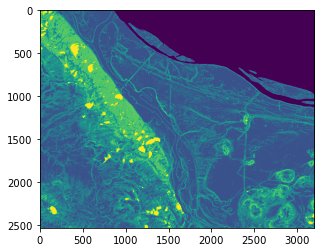

In [13]:
f, ax=plt.subplots()
ax.imshow(a);

### Opening as Numpy Array

In [14]:
with rio.open(path_ls) as ls_array:
    r = ls_array.read(1)
r

array([[3, 3, 3, ..., 0, 0, 0],
       [3, 3, 3, ..., 0, 0, 0],
       [3, 3, 3, ..., 0, 0, 0],
       ...,
       [2, 2, 2, ..., 3, 2, 2],
       [1, 1, 2, ..., 3, 3, 2],
       [1, 1, 1, ..., 3, 3, 2]], dtype=uint16)

### Eliminate nondata values

In [15]:
import numpy.ma as ma
mask = ma.masked_equal(r, 0)
mask

masked_array(
  data=[[3, 3, 3, ..., --, --, --],
        [3, 3, 3, ..., --, --, --],
        [3, 3, 3, ..., --, --, --],
        ...,
        [2, 2, 2, ..., 3, 2, 2],
        [1, 1, 2, ..., 3, 3, 2],
        [1, 1, 1, ..., 3, 3, 2]],
  mask=[[False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],
  fill_value=0,
  dtype=uint16)

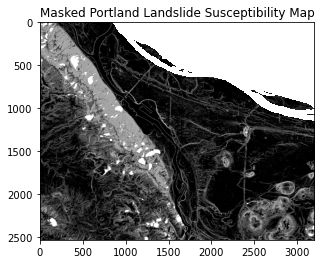

In [16]:
# Quick plot
f, ax = plt.subplots()
ax.imshow(mask, cmap = 'gray')
ax.set_title('Masked Portland Landslide Susceptibility Map');

### Histogram of raster data

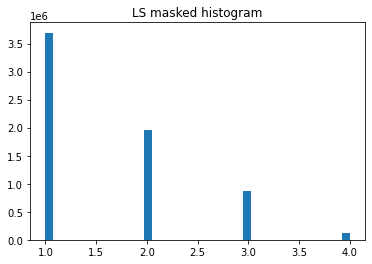

In [17]:
# ravel before hist plot
ls_masked = np.ravel(mask)
# hist plot
plt.hist(ls_masked, bins = 40)
plt.title('LS masked histogram')
plt.show()

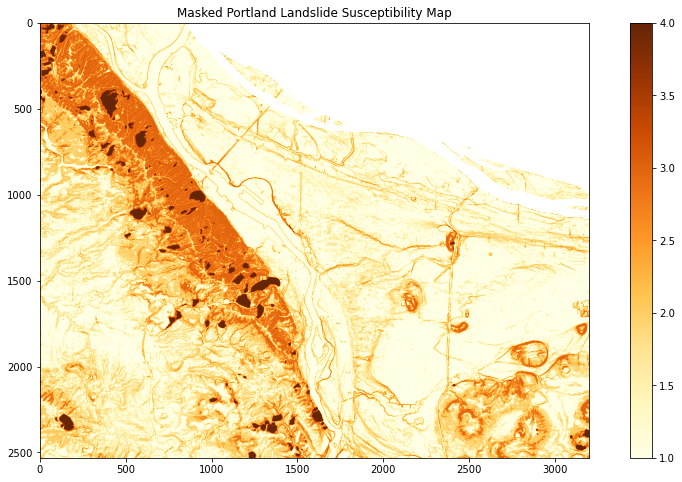

In [18]:
# Plot with coloramp
%matplotlib inline
f, ax = plt.subplots(figsize=(15,8))
lsmap = ax.imshow(mask, cmap='YlOrBr')
f.colorbar(lsmap, ax=ax)
ax.set_title('Masked Portland Landslide Susceptibility Map');

### Reprojection of ls raster data 
Reprojection with rasterio

* Function to reproject raster

In [19]:
def rio_reproj_write(src, proj_fn, dst_crs, driver='GTiff'):
    #Check to see if output filename already exists
    if os.path.exists(proj_fn):
        print("File exists: ", proj_fn)
    else:
        #Get the required transformation and output width and height
        transform, width, height = calculate_default_transform(src.crs, dst_crs, src.width, src.height, *src.bounds)
        #Create a copy of input metadata, then update with output values
        kwargs = src.meta.copy()
        print("Source metadata:\n", kwargs)
        kwargs.update({'crs':dst_crs,'transform':transform,'width':width,'height':height})
        kwargs['driver'] = driver
        #Set output creation options
        kwargs['compress'] = 'LZW'
        kwargs['tiled'] = True
        kwargs['BIGTIFF'] = 'IF_SAFER'
        print("Destination metadata:\n", kwargs)

        #Open the destination dataset in write mode
        with rio.open(proj_fn, 'w', **kwargs) as dst:
            print("Writing: ", proj_fn)
            #Loop through each input band
            for i in range(1, src.count + 1):
                #Reproject!
                reproject(source=rio.band(src, i), destination=rio.band(dst, i), src_transform=src.transform,\
                          src_crs=src.crs, dst_transform=transform, dst_crs=dst_crs, resampling=Resampling.cubic)
            print("Complete")

* Execute def function to reproject raster

In [20]:
src = rio.open(path_ls)
proj_fn = os.path.splitext(path_ls)[0]+'_utm_riowarp1.tif'
rio_reproj_write(src, proj_fn, proj)

File exists:  project_data/Portland_LSM_utm_riowarp1.tif


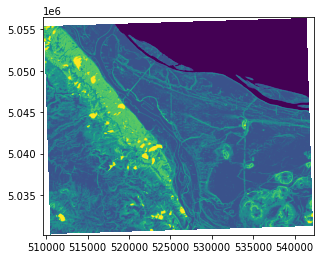

In [21]:
# open reprojected data and quick plot
with rio.open(proj_fn) as src_proj:
    rio.plot.show(src_proj)

In [22]:
#Load as a masked array
src_proj = rio.open(proj_fn)
ls_proj = src_proj.read(1, masked=True)

In [23]:
# Getting extent of masked raster array
ls_extent = rio.plot.plotting_extent(src_proj)

## Part 2: Clip LS raster data to study area 
Use of Portland's neighborhood vector data to define study area
* Load and explore neighborhood data
* Define Neighborhood (n) vector data to clip and limit study area

### Loading and exploring neighborhood vector data

In [24]:
%pwd

'/home/jovyan/landslide_exposure_portland'

In [25]:
# Defining neighborhood vector data path
path_neigh = 'project_data/portland_neighborhoods_boundaries.gpkg'

In [26]:
# Define neighborhood variable (n) as geopandas geodataframe 
n = gpd.read_file(path_neigh)
# Quick exploration of attributes
n.head()

/srv/conda/envs/notebook/lib/python3.8/site-packages/geopandas/geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


OBJECTID                 NAME COMMPLAN SHARED COALIT HORZ_VERT  \
0         1              LINNTON     None      N   NWNW      HORZ   
1         2  FOREST PARK/LINNTON     None      Y   NWNW      None   
2         3          FOREST PARK     None      N   NWNW      HORZ   
3         4       CATHEDRAL PARK     None      N   NPNS      HORZ   
4         5      UNIVERSITY PARK     None      N   NPNS      HORZ   

     Shape_Leng             MAPLABEL  ID  \
0  52741.719772              Linnton   1   
1  57723.635350  Forest Park/Linnton   2   
2  82725.497522          Forest Park   3   
3  11434.254777       Cathedral Park   4   
4  11950.859827      University Park   5   

                                            geometry  
0  MULTIPOLYGON (((-13672672.739 5717458.926, -13...  
1  MULTIPOLYGON (((-13672615.072 5717458.598, -13...  
2  MULTIPOLYGON (((-13669096.892 5708277.357, -13...  
3  MULTIPOLYGON (((-13666093.373 5714122.821, -13...  
4  MULTIPOLYGON (((-13663193.115 5713925.450, -13...

<AxesSubplot:>

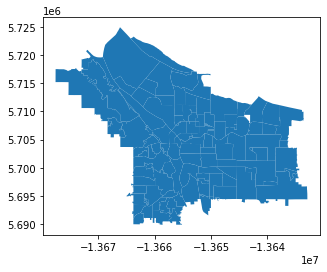

In [27]:
# Quick plot
n.plot()

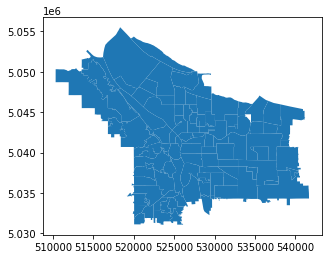

In [28]:
# Reprojecting neighborhood boundaries
n_rp = n.to_crs(proj)

# Plotting for sanity check
n_rp.plot();

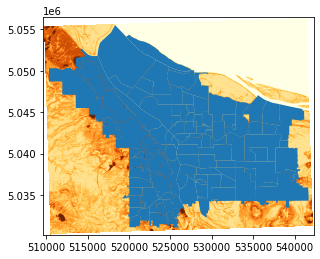

In [29]:
# Sanity check of n and ls data together
f, ax = plt.subplots()
ax.imshow(ls_proj, cmap='YlOrBr', extent=ls_extent)
n_rp.plot(ax=ax);

#### Clip ls raster within defined limits (n)

In [30]:
# Defining gometry variable of reprojected 'n'
n_geom = n_rp.geometry
n_geom

0      MULTIPOLYGON (((513747.148 5050305.636, 513751...
1      MULTIPOLYGON (((513787.545 5050305.496, 513796...
2      MULTIPOLYGON (((516268.709 5043897.792, 516189...
3      MULTIPOLYGON (((518362.864 5047987.762, 518028...
4      MULTIPOLYGON (((520395.714 5047856.199, 520611...
                             ...                        
125    MULTIPOLYGON (((525076.331 5047124.948, 524802...
126    MULTIPOLYGON (((526745.767 5049929.252, 527148...
127    MULTIPOLYGON (((526504.247 5049604.548, 526552...
128    MULTIPOLYGON (((528051.151 5049797.770, 528099...
129    MULTIPOLYGON (((522782.965 5047950.654, 522783...
Name: geometry, Length: 130, dtype: geometry

In [31]:
# Clip for Portland Nieghborhoods with rio mask mask 
# Variable name: po_ma (portland oregon masked)
rio_mask_kwargs = {'filled':False, 'crop':True, 'indexes':1}
po_ma, po_ma_transform = rio.mask.mask(src_proj, n_geom, **rio_mask_kwargs)

In [32]:
# Checking shape
po_ma.shape

(2449, 3140)

In [33]:
# Checking affine boundaries
po_ma_transform

Affine(9.995920557111234, 0.0, 510319.3414050439,
       0.0, -9.995920557111234, 5055524.507531572)

In [34]:
#Get clipped extent in UTM coordaintes for plotting
po_ma_extent = rio.plot.plotting_extent(po_ma, po_ma_transform)
po_ma_extent

(510319.3414050439, 541706.5319543732, 5031044.498087207, 5055524.507531572)

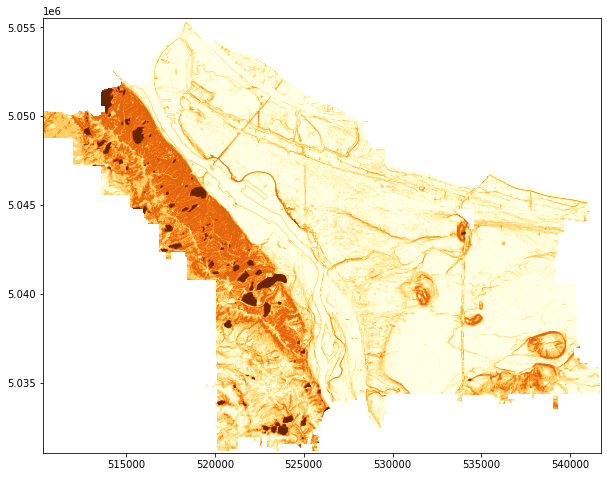

In [35]:
# Sanity check using po_ma
f, ax = plt.subplots(figsize=(15,8))
po_map = ax.imshow(po_ma, extent=po_ma_extent, cmap = 'YlOrBr', vmin=1, vmax=4);

In [36]:
# Need mask
# Mask clipped raster data
ls_ma = ma.masked_equal(po_ma, 0)
ls_ma

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=0,
  dtype=uint16)

AttributeError: 'AxesSubplot' object has no attribute 'colorbar'

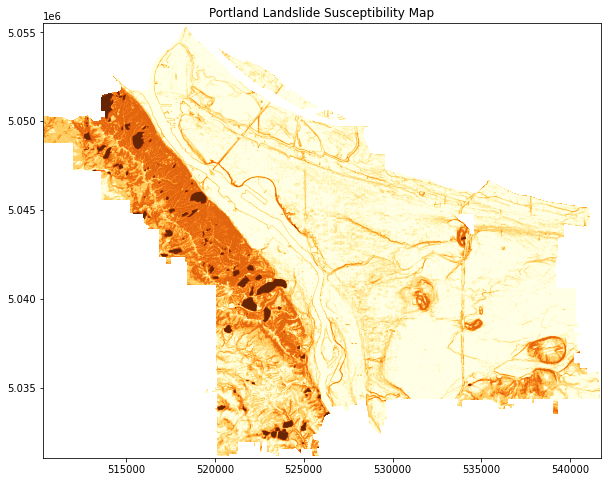

In [37]:
# Final Check using ls_ma as final raster product
f, ax = plt.subplots(figsize=(15,8))
ax.imshow(ls_ma, extent=po_ma_extent, cmap = 'YlOrBr')
ax.set_title('Portland Landslide Susceptibility Map')
ax.colorbar;

## Part 3: Building footprint (bf)
* Load and explore bf vector data
* Reproject bf to project's projection

In [38]:
# Defining path for building footprint
path_bf = 'project_data/portland_building_footprint.gpkg'

In [39]:
# Variable for building footprint data (bf)
bf = gpd.read_file(path_bf)
bf.head()

/srv/conda/envs/notebook/lib/python3.8/site-packages/geopandas/geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


OBJECTID           BLDG_ID        STATE_ID  BLDG_NUMB BLDG_STAT  \
0        80  1N1W01DA-7900-B1  1N1W01DA  7900        1.0  EXISTING   
1        82  1N1E07CA-7800-B2  1N1E07CA  7800        2.0  EXISTING   
2        89  1N1W01CB-3200-B1  1N1W01CB  3200        1.0  EXISTING   
3       163    2N1W26-800-B21   2N1W26    800       21.0  EXISTING   
4       176  1N1W01BD-5800-B1  1N1W01BD  5800        1.0  EXISTING   

                BLDG_NAME               BLDG_ADDR BLDG_TYPE  \
0       8135 N OLYMPIA ST       8135 N OLYMPIA ST     House   
1       6711 N AMHERST ST       6711 N AMHERST ST    Garage   
2       9665 N KELLOGG ST       9665 N KELLOGG ST     House   
3  14400 N RIVERGATE BLVD  14400 N RIVERGATE BLVD      None   
4        10016 N JAMES ST        10016 N JAMES ST     House   

                    BLDG_USE  BLDG_SQFT  ...      ORIENT   VOLUME Shape_Leng  \
0  Single Family Residential     1324.0  ...         NaN  24408.0  82.255414   
1  Single Family Residential      554.0  ...         NaN   4875.0  44.618188   
2  Single Family Residential     1384.0  ...  120.763000  19414.0  81.154237   
3  Single Family Residential     2325.0  ...   71.388298  51175.0  84.873482   
4  Single Family Residential      688.0  ... -159.205002  15177.0  63.291208   

   Shape_Area   PROPKEY  EDIT_STAT DATA_SOURC RETIRED_BY  RETIRED_DA  \
0  310.967219  653404.0    CURRENT        PDX       None        None   
1  121.956227  653406.0    CURRENT        PDX       None        None   
2  300.281235  653413.0    CURRENT        PDX       None        None   
3  442.060692  653488.0    CURRENT        PDX       None        None   
4  205.587118  653501.0    CURRENT        PDX       None        None   

                                            geometry  
0  MULTIPOLYGON (((-13664023.843 5716110.710, -13...  
1  MULTIPOLYGON (((-13663140.644 5713654.765, -13...  
2  MULTIPOLYGON (((-13665539.575 5715962.379, -13...  
3  MULTIPOLYGON (((-13668087.946 5720924.525, -13...  
4  MULTIPOLYGON (((-13665270.868 5716671.006, -13...  

[5 rows x 43 columns]

In [40]:
bf.total_bounds

array([-13677551.185 ,   5689879.171 , -13632943.7533,   5724379.2045])

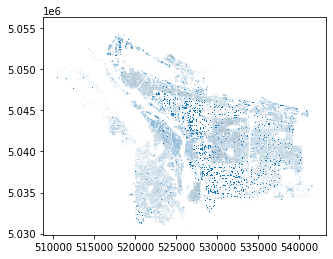

In [41]:
# Reprojecting polygons
b_rp = bf.to_crs(proj)
# Quick plot for sanity check
b_rp.plot();

### Combination of LS and BF maps

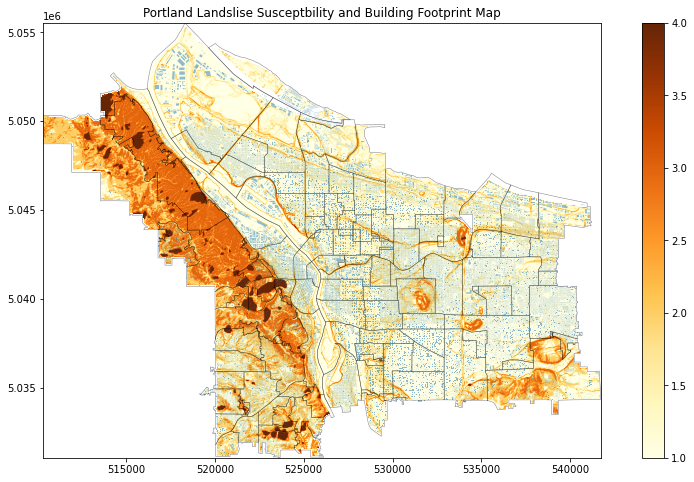

In [42]:
# Plot of all data
# %matplotlib widget
%matplotlib inline
f, ax = plt.subplots(figsize=(15,8))
po_map = ax.imshow(ls_ma, extent=po_ma_extent, cmap = 'YlOrBr', vmin=1, vmax=4)
f.colorbar(po_map, ax=ax)
n_bound = n_rp.plot(ax=ax, facecolor='None', edgecolor='k', alpha=0.5, lw=0.5)
build = b_rp.plot(ax=ax, alpha=0.5)
ax.set_title('Portland Landslise Susceptbility and Building Footprint Map');

## Part IV: Sampling and statistics applied to Building Footprint to assign LS index to each BF
* Count number of polygons
* Explore the "BLDG_USE" column and create new DataFrame for each
* Calculate the area of the polygons
* Assign LS index to each polygon using centroid or median buffer

In [43]:
b_rp.shape

(247200, 43)

In [44]:
b_rp['BLDG_USE'].value_counts()

Single Family Residential    223162
Multi Family Residential      16297
Not Set                         707
Commercial Office               628
Industrial                      528
Commercial Retail               384
Institutional                   159
Commercial Restaurant           134
Parking                         110
Vacant                           87
Commercial Hotel                 54
Institutional Religious          36
Commercial General                6
Commercial Grocery                3
TOWNHOUSE                         1
Name: BLDG_USE, dtype: int64

In [45]:
# b_rp['BLDG_TYPE'].value_counts()

### Isolate Residential Properties: Single and Multi family

In [46]:
# isolating single family residential buildings
b_sinfam = b_rp.loc[b_rp['BLDG_USE'] == 'Single Family Residential']
# isolating multi family residential buildings
b_mulfam = b_rp.loc[b_rp['BLDG_USE'] == 'Multi Family Residential']

In [47]:
# Number of single and multi family buildings
print('The number of residential single familiy is', len(b_sinfam), 'and multi family is', len(b_mulfam))

The number of residential single familiy is 223162 and multi family is 16297


#### Reducing GDF attributes

In [48]:
# Reducing data to Building Type (BLDG_TYPE), Reported SQFT (BLDG_SQFT), and geometry feature
# b: building; sinfam: Single Family; r: reduced
b_sinfam_r = b_sinfam[['BLDG_TYPE', 'BLDG_USE', 'BLDG_SQFT', 'Shape_Leng', 'Shape_Area', 'geometry']].copy()
b_sinfam_r.head()

BLDG_TYPE                   BLDG_USE  BLDG_SQFT  Shape_Leng  Shape_Area  \
0     House  Single Family Residential     1324.0   82.255414  310.967219   
1    Garage  Single Family Residential      554.0   44.618188  121.956227   
2     House  Single Family Residential     1384.0   81.154237  300.281235   
3      None  Single Family Residential     2325.0   84.873482  442.060692   
4     House  Single Family Residential      688.0   63.291208  205.587118   

                                            geometry  
0  MULTIPOLYGON (((519808.722 5049380.495, 519804...  
1  MULTIPOLYGON (((520433.102 5047667.249, 520436...  
2  MULTIPOLYGON (((518747.096 5049273.640, 518749...  
3  MULTIPOLYGON (((516952.255 5052732.744, 516947...  
4  MULTIPOLYGON (((518933.860 5049769.035, 518935...

In [49]:
b_mulfam_r = b_mulfam[['BLDG_TYPE', 'BLDG_USE', 'BLDG_SQFT', 'Shape_Leng', 'Shape_Area', 'geometry']].copy()
b_mulfam_r.head()

BLDG_TYPE                  BLDG_USE  BLDG_SQFT  Shape_Leng  \
97   Apartment Complex  Multi Family Residential     4801.0  167.466408   
102             Duplex  Multi Family Residential     3020.0   77.472361   
105             Duplex  Multi Family Residential     3367.0   74.369329   
132  Apartment Complex  Multi Family Residential     2784.0  116.154005   
174          Multiplex  Multi Family Residential     2985.0  103.539271   

     Shape_Area                                           geometry  
97   910.854747  MULTIPOLYGON (((519218.677 5049543.114, 519222...  
102  285.440784  MULTIPOLYGON (((518339.648 5049100.463, 518340...  
105  319.858534  MULTIPOLYGON (((519603.909 5045691.371, 519610...  
132  528.670379  MULTIPOLYGON (((519406.967 5049933.042, 519408...  
174  564.981863  MULTIPOLYGON (((518589.605 5049359.402, 518600...

### I. Working with Multi Family Residential buildings
#### Assign Landslide Susceptibility class exploring:
* Rio Sample (selected method)

In [50]:
# geometry area and centroid // Adding columns
b_mulfam_r['area']= b_mulfam_r.geometry.area
b_mulfam_r['centroid']= b_mulfam_r.geometry.centroid

In [51]:
b_mulfam_r.head()

BLDG_TYPE                  BLDG_USE  BLDG_SQFT  Shape_Leng  \
97   Apartment Complex  Multi Family Residential     4801.0  167.466408   
102             Duplex  Multi Family Residential     3020.0   77.472361   
105             Duplex  Multi Family Residential     3367.0   74.369329   
132  Apartment Complex  Multi Family Residential     2784.0  116.154005   
174          Multiplex  Multi Family Residential     2985.0  103.539271   

     Shape_Area                                           geometry  \
97   910.854747  MULTIPOLYGON (((519218.677 5049543.114, 519222...   
102  285.440784  MULTIPOLYGON (((518339.648 5049100.463, 518340...   
105  319.858534  MULTIPOLYGON (((519603.909 5045691.371, 519610...   
132  528.670379  MULTIPOLYGON (((519406.967 5049933.042, 519408...   
174  564.981863  MULTIPOLYGON (((518589.605 5049359.402, 518600...   

           area                        centroid  
97   445.610775  POINT (519227.672 5049522.418)  
102  139.663033  POINT (518340.580 5049091.297)  
105  156.673327  POINT (519613.273 5045689.548)  
132  258.604442  POINT (519405.404 5049924.641)  
174  276.415723  POINT (518602.664 5049361.040)

In [52]:
# Defining centroid variable for multi familiy
c_mulfam = b_mulfam_r['centroid']

In [53]:
# Comprehensive list for rio sampling
mulfam_xy = [(pt.x, pt.y) for pt in c_mulfam.geometry]

#### Rio sample method

In [54]:
# Rio sample
b_mulfam_sample = np.fromiter(src_proj.sample(mulfam_xy), dtype=ls_ma.dtype) 

In [55]:
# Sanity check
print('min =', b_mulfam_sample.min())
print('max =', b_mulfam_sample.max())

min = 0
max = 4


In [56]:
# Transform sample data to float
b_mulfam_sample = b_mulfam_sample.astype(float)
# Nodata as NaN
b_mulfam_sample[b_mulfam_sample == src_proj.nodata] = np.nan

In [57]:
# Adding sample to a column
b_mulfam_r['ls_rio_sample'] = b_mulfam_sample
b_mulfam_r.head()

BLDG_TYPE                  BLDG_USE  BLDG_SQFT  Shape_Leng  \
97   Apartment Complex  Multi Family Residential     4801.0  167.466408   
102             Duplex  Multi Family Residential     3020.0   77.472361   
105             Duplex  Multi Family Residential     3367.0   74.369329   
132  Apartment Complex  Multi Family Residential     2784.0  116.154005   
174          Multiplex  Multi Family Residential     2985.0  103.539271   

     Shape_Area                                           geometry  \
97   910.854747  MULTIPOLYGON (((519218.677 5049543.114, 519222...   
102  285.440784  MULTIPOLYGON (((518339.648 5049100.463, 518340...   
105  319.858534  MULTIPOLYGON (((519603.909 5045691.371, 519610...   
132  528.670379  MULTIPOLYGON (((519406.967 5049933.042, 519408...   
174  564.981863  MULTIPOLYGON (((518589.605 5049359.402, 518600...   

           area                        centroid  ls_rio_sample  
97   445.610775  POINT (519227.672 5049522.418)            1.0  
102  139.663033  POINT (518340.580 5049091.297)            1.0  
105  156.673327  POINT (519613.273 5045689.548)            2.0  
132  258.604442  POINT (519405.404 5049924.641)            2.0  
174  276.415723  POINT (518602.664 5049361.040)            1.0

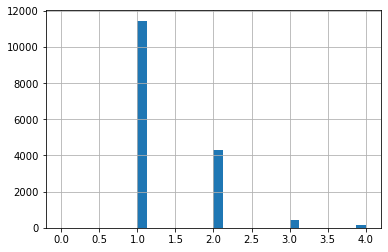

In [58]:
%matplotlib inline
b_mulfam_r['ls_rio_sample'].hist(bins=32);

#### Multi Familiy Group by LS sample

In [59]:
b_mulfam_stats = b_mulfam_r.groupby('ls_rio_sample').agg('sum')
b_mulfam_stats.head()

BLDG_SQFT    Shape_Leng    Shape_Area          area
ls_rio_sample                                                      
0.0               14857.0  3.967517e+02  2.256317e+03  1.103488e+03
1.0            75329418.0  1.200807e+06  6.507718e+06  3.192473e+06
2.0            33272820.0  4.698264e+05  2.618294e+06  1.284845e+06
3.0             2875335.0  4.685072e+04  2.570422e+05  1.261475e+05
4.0             1839383.0  1.558059e+04  9.979548e+04  4.896318e+04

In [60]:
# Sanity check area from stats variable
b_mulfam_stats['area'].sum()

4653532.711984256

In [61]:
# Area of original gdf
b_mulfam_r['area'].sum()

4653532.7119842395

In [62]:
b_mulfam_r.shape

(16297, 9)

### II. Working with Single Family Residential buildings
#### Assign Landslide Susceptibility class exploring:
* Rio Sample

In [63]:
# geometry area and centroid // Adding columns
b_sinfam_r['area']= b_sinfam_r.geometry.area
b_sinfam_r['centroid']= b_sinfam_r.geometry.centroid

In [64]:
c_sinfam = b_sinfam_r['centroid']
# Coordinates to pass rio sample
sinfam_xy = [(pt.x, pt.y) for pt in c_sinfam.geometry]

In [65]:
# rio sample
b_sinfam_sample = np.fromiter(src_proj.sample(sinfam_xy), dtype=ls_ma.dtype) 

In [66]:
# Passing sample data to float type
b_sinfam_sample = b_sinfam_sample.astype(float)
# Defining no data as NaN
b_sinfam_sample[b_sinfam_sample == src_proj.nodata] = np.nan

In [67]:
# Adding sample to column
b_sinfam_r['ls_rio_sample'] = b_sinfam_sample
b_sinfam_r.head()

BLDG_TYPE                   BLDG_USE  BLDG_SQFT  Shape_Leng  Shape_Area  \
0     House  Single Family Residential     1324.0   82.255414  310.967219   
1    Garage  Single Family Residential      554.0   44.618188  121.956227   
2     House  Single Family Residential     1384.0   81.154237  300.281235   
3      None  Single Family Residential     2325.0   84.873482  442.060692   
4     House  Single Family Residential      688.0   63.291208  205.587118   

                                            geometry        area  \
0  MULTIPOLYGON (((519808.722 5049380.495, 519804...  152.139377   
1  MULTIPOLYGON (((520433.102 5047667.249, 520436...   59.699265   
2  MULTIPOLYGON (((518747.096 5049273.640, 518749...  146.916295   
3  MULTIPOLYGON (((516952.255 5052732.744, 516947...  216.044367   
4  MULTIPOLYGON (((518933.860 5049769.035, 518935...  100.570121   

                         centroid  ls_rio_sample  
0  POINT (519803.165 5049378.541)            1.0  
1  POINT (520435.835 5047662.429)            1.0  
2  POINT (518743.312 5049265.288)            1.0  
3  POINT (516943.669 5052726.563)            1.0  
4  POINT (518934.086 5049762.521)            1.0

#### Single Familiy Group by sample

In [68]:
b_sinfam_stats = b_sinfam_r.groupby('ls_rio_sample').agg('sum')
b_sinfam_stats.head()

BLDG_SQFT    Shape_Leng    Shape_Area          area
ls_rio_sample                                                       
0.0              1687378.0  5.677286e+04  2.776601e+05  1.347322e+05
1.0            395891906.0  1.170488e+07  6.196746e+07  3.037049e+07
2.0            122259953.0  3.828919e+06  1.733721e+07  8.505467e+06
3.0             20684624.0  5.350471e+05  2.578841e+06  1.261478e+06
4.0              3745833.0  1.249314e+05  5.944973e+05  2.916571e+05

## Part V. Results and Interpretation
* Percent of residential buildings exposed to each susceptibility class

#### % of the total BF area under each LS class

In [69]:
# Using rio sample values:
b_mulfam_stats['% of area in ls_class'] = 100*round(b_mulfam_stats['area']/b_mulfam_stats['area'].sum(),2)
b_sinfam_stats['% of area in ls_class'] = 100*round(b_sinfam_stats['area']/b_sinfam_stats['area'].sum(),2)

In [70]:
# Merge both dataframe with concatenate
merge_stats = [b_mulfam_stats, b_sinfam_stats]
b_residential_concat = pd.concat(merge_stats, join="inner")

In [71]:
b_residential_concat

BLDG_SQFT    Shape_Leng    Shape_Area          area  \
ls_rio_sample                                                          
0.0                14857.0  3.967517e+02  2.256317e+03  1.103488e+03   
1.0             75329418.0  1.200807e+06  6.507718e+06  3.192473e+06   
2.0             33272820.0  4.698264e+05  2.618294e+06  1.284845e+06   
3.0              2875335.0  4.685072e+04  2.570422e+05  1.261475e+05   
4.0              1839383.0  1.558059e+04  9.979548e+04  4.896318e+04   
0.0              1687378.0  5.677286e+04  2.776601e+05  1.347322e+05   
1.0            395891906.0  1.170488e+07  6.196746e+07  3.037049e+07   
2.0            122259953.0  3.828919e+06  1.733721e+07  8.505467e+06   
3.0             20684624.0  5.350471e+05  2.578841e+06  1.261478e+06   
4.0              3745833.0  1.249314e+05  5.944973e+05  2.916571e+05   

               % of area in ls_class  
ls_rio_sample                         
0.0                              0.0  
1.0                             69.0  
2.0                             28.0  
3.0                              3.0  
4.0                              1.0  
0.0                              0.0  
1.0                             75.0  
2.0                             21.0  
3.0                              3.0  
4.0                              1.0

In [72]:
b_residential_concat['% of total in ls_class'] = 100*round(b_residential_concat['area']/b_residential_concat['area'].sum(),2)
b_residential_concat

BLDG_SQFT    Shape_Leng    Shape_Area          area  \
ls_rio_sample                                                          
0.0                14857.0  3.967517e+02  2.256317e+03  1.103488e+03   
1.0             75329418.0  1.200807e+06  6.507718e+06  3.192473e+06   
2.0             33272820.0  4.698264e+05  2.618294e+06  1.284845e+06   
3.0              2875335.0  4.685072e+04  2.570422e+05  1.261475e+05   
4.0              1839383.0  1.558059e+04  9.979548e+04  4.896318e+04   
0.0              1687378.0  5.677286e+04  2.776601e+05  1.347322e+05   
1.0            395891906.0  1.170488e+07  6.196746e+07  3.037049e+07   
2.0            122259953.0  3.828919e+06  1.733721e+07  8.505467e+06   
3.0             20684624.0  5.350471e+05  2.578841e+06  1.261478e+06   
4.0              3745833.0  1.249314e+05  5.944973e+05  2.916571e+05   

               % of area in ls_class  % of total in ls_class  
ls_rio_sample                                                 
0.0                              0.0                     0.0  
1.0                             69.0                     7.0  
2.0                             28.0                     3.0  
3.0                              3.0                     0.0  
4.0                              1.0                     0.0  
0.0                              0.0                     0.0  
1.0                             75.0                    67.0  
2.0                             21.0                    19.0  
3.0                              3.0                     3.0  
4.0                              1.0                     1.0

In [73]:
# Sanity check
b_residential_concat['% of total in ls_class'].sum()

100.0

In [74]:
b_mulfam_stats.head()

BLDG_SQFT    Shape_Leng    Shape_Area          area  \
ls_rio_sample                                                         
0.0               14857.0  3.967517e+02  2.256317e+03  1.103488e+03   
1.0            75329418.0  1.200807e+06  6.507718e+06  3.192473e+06   
2.0            33272820.0  4.698264e+05  2.618294e+06  1.284845e+06   
3.0             2875335.0  4.685072e+04  2.570422e+05  1.261475e+05   
4.0             1839383.0  1.558059e+04  9.979548e+04  4.896318e+04   

               % of area in ls_class  
ls_rio_sample                         
0.0                              0.0  
1.0                             69.0  
2.0                             28.0  
3.0                              3.0  
4.0                              1.0

In [75]:
b_sinfam_stats.head()

BLDG_SQFT    Shape_Leng    Shape_Area          area  \
ls_rio_sample                                                          
0.0              1687378.0  5.677286e+04  2.776601e+05  1.347322e+05   
1.0            395891906.0  1.170488e+07  6.196746e+07  3.037049e+07   
2.0            122259953.0  3.828919e+06  1.733721e+07  8.505467e+06   
3.0             20684624.0  5.350471e+05  2.578841e+06  1.261478e+06   
4.0              3745833.0  1.249314e+05  5.944973e+05  2.916571e+05   

               % of area in ls_class  
ls_rio_sample                         
0.0                              0.0  
1.0                             75.0  
2.0                             21.0  
3.0                              3.0  
4.0                              1.0

In [76]:
b_residential_stats_area = b_residential_concat.groupby('ls_rio_sample').agg('sum')
b_residential_stats_area

BLDG_SQFT    Shape_Leng    Shape_Area          area  \
ls_rio_sample                                                          
0.0              1702235.0  5.716962e+04  2.799165e+05  1.358357e+05   
1.0            471221324.0  1.290569e+07  6.847518e+07  3.356297e+07   
2.0            155532773.0  4.298746e+06  1.995551e+07  9.790312e+06   
3.0             23559959.0  5.818978e+05  2.835883e+06  1.387625e+06   
4.0              5585216.0  1.405120e+05  6.942928e+05  3.406203e+05   

               % of area in ls_class  % of total in ls_class  
ls_rio_sample                                                 
0.0                              0.0                     0.0  
1.0                            144.0                    74.0  
2.0                             49.0                    22.0  
3.0                              6.0                     3.0  
4.0                              2.0                     1.0

### Plot of results

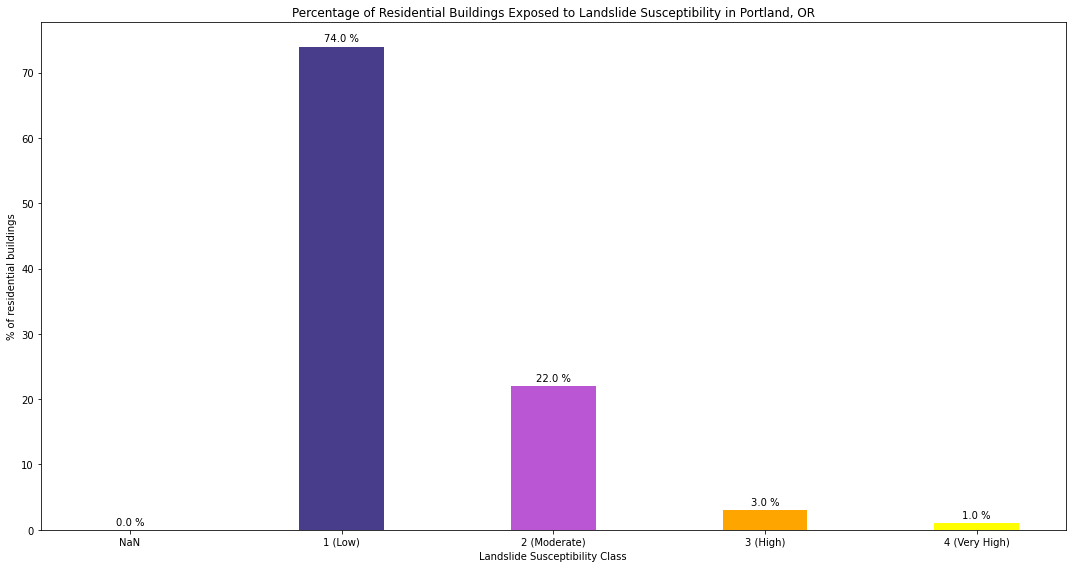

In [77]:
# Representing results in a bar plot
result = np.array(b_residential_stats_area['% of total in ls_class'])
# x_axis = ([0,1,2,3,4])
x_axis = (['NaN', '1 (Low)', '2 (Moderate)', '3 (High)', '4 (Very High)'])
colors = ['k', 'darkslateblue','mediumorchid','orange','yellow']

f, ax=plt.subplots(figsize=(15,8))
ls_class_results = ax.bar(x_axis, result, width=0.40, color=colors, align='center')
# Labeling each bar
def barlabel(ls_class):
    for ls_class in ls_class:
        height = ls_class.get_height()
        ax.annotate('{} %'.format(height),
                    xy=(ls_class.get_x() + ls_class.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
barlabel(ls_class_results)
ax.set_title('Percentage of Residential Buildings Exposed to Landslide Susceptibility in Portland, OR')
ax.set_xlabel('Landslide Susceptibility Class')
ax.set_ylabel('% of residential buildings')
f.tight_layout()
plt.show();
# save image
# plt.savefig('ls_building_exposure_distribution_portland.png');

In [78]:
b_residential_stats_area['% of total in ls_class'].describe

<bound method NDFrame.describe of ls_rio_sample
0.0     0.0
1.0    74.0
2.0    22.0
3.0     3.0
4.0     1.0
Name: % of total in ls_class, dtype: float64>

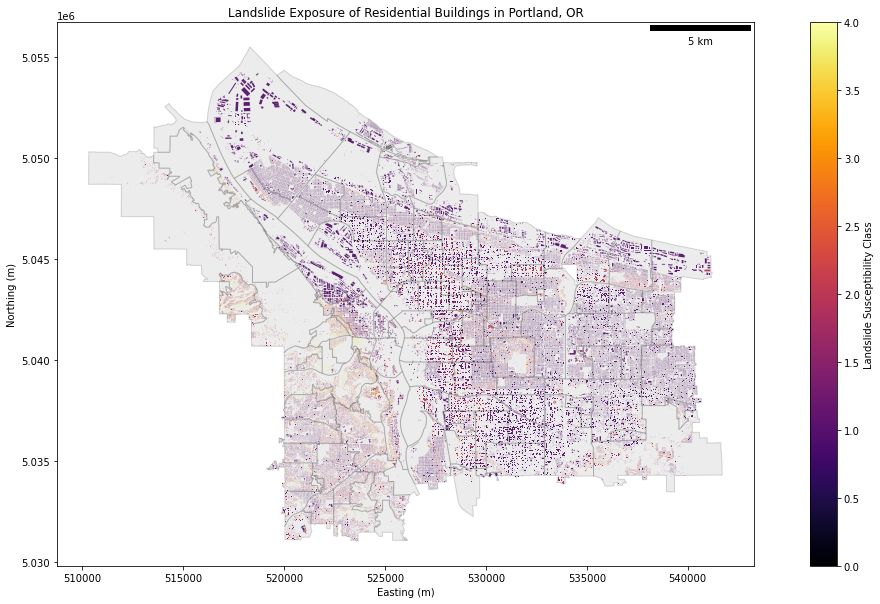

In [79]:
# Plot buildings with each Susceptibility Class using inferno for better visualization
from matplotlib_scalebar.scalebar import ScaleBar

f, ax = plt.subplots(figsize=(20,10))
b_mulfam_r.plot(ax=ax, column = 'ls_rio_sample', cmap='inferno', vmin=0, legend=True, legend_kwds={'label': 'Landslide Susceptibility Class'})
b_sinfam_r.plot(ax=ax, column = 'ls_rio_sample', cmap='inferno', vmin=0)
n_bound = n_rp.plot(ax=ax, facecolor='grey', alpha=0.15, edgecolor='k', lw=1)
ax.set_title('Landslide Exposure of Residential Buildings in Portland, OR')
ax.set_xlabel('Easting (m)')
ax.set_ylabel('Northing (m)')
ax.add_artist(ScaleBar(1.0));
# save image
# plt.savefig('ls_building_exposure_portland.png');

In [80]:
# Plot of centroids for extra visualization option

# extract x,y coordinates from centroid
x_mul = b_mulfam_r['centroid'].x
x_sin = b_sinfam_r['centroid'].x
y_mul = b_mulfam_r['centroid'].y
y_sin = b_sinfam_r['centroid'].y

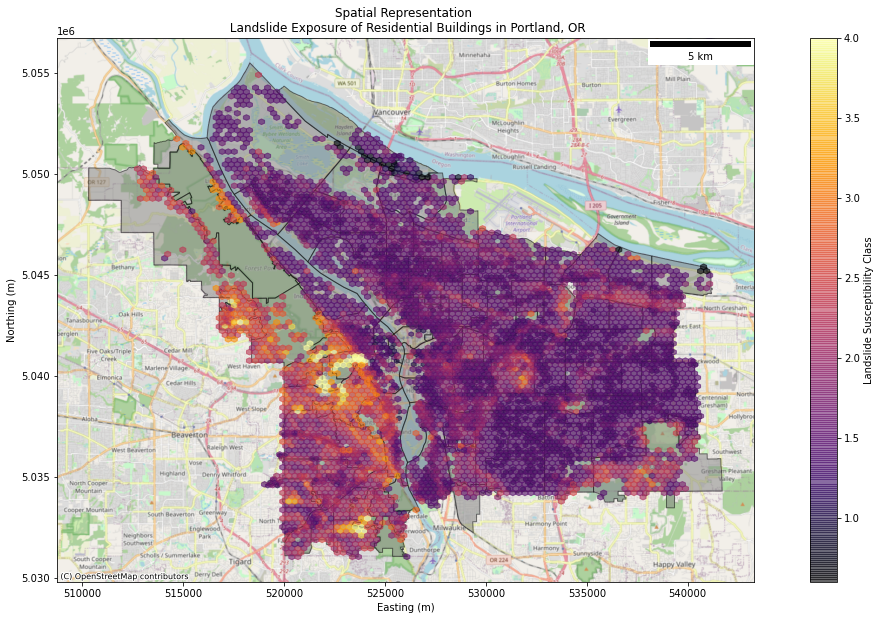

In [81]:
import contextily as ctx
# plot with hexbin
f, ax=plt.subplots(figsize=(20,10))
n_rp.plot(ax=ax, facecolor='grey', alpha=0.5, edgecolor='k', lw=1)
hb_mul = ax.hexbin(x_mul, y_mul, C=b_mulfam_r['ls_rio_sample'], alpha=0.6, gridsize=100, mincnt=1, cmap='inferno')
hb_sin = ax.hexbin(x_sin, y_sin, C=b_sinfam_r['ls_rio_sample'], alpha=0.6, gridsize=100, mincnt=1, cmap='inferno')
ax.set_title('Spatial Representation \n Landslide Exposure of Residential Buildings in Portland, OR')
ax.set_xlabel('Easting (m)')
ax.set_ylabel('Northing (m)')
ax.add_artist(ScaleBar(1.0))
cd = f.colorbar(hb_mul, ax=ax)
cd.set_label('Landslide Susceptibility Class')

# Add basemap
ctx.add_basemap(ax=ax, crs=n_rp.crs, source=ctx.providers.OpenStreetMap.Mapnik);

# save image
# plt.savefig('ls_exposure_portland.png');

## Adding "Mapping Inequality Maps" - Redlining

In [82]:
%pwd

'/home/jovyan/landslide_exposure_portland'

In [83]:
path_redline = r'project_data/Redlining_map.gpkg'

In [84]:
# Define redlining variable (redline) as geopandas geodataframe 
redline = gpd.read_file(path_redline)
# Quick exploration of attributes
redline.head()

/srv/conda/envs/notebook/lib/python3.8/site-packages/geopandas/geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


name holc_id holc_grade  \
0            Gainsborough      A1          A   
1  South Portland Heights     A10          A   
2           Council Crest     A11          A   
3     Tervilliger Heights     A12          A   
4            Eastmoreland     A13          A   

                               area_description_data      area  perimeter  \
0  { "5": "A deed restricted area, at present zon...  0.000010   0.012835   
1  { "5": "Deed restrictions have expired but zon...  0.000084   0.062664   
2  { "5": "Deed restrictions are said to have exp...  0.000075   0.057182   
3  { "5": "Deed restrictions have expired but zon...  0.000047   0.029318   
4  { "5": "Zoned single-family residential. (Deed...  0.000116   0.045370   

                                            geometry  
0  MULTIPOLYGON (((-122.67478 45.56675, -122.6747...  
1  MULTIPOLYGON (((-122.70386 45.50984, -122.7038...  
2  MULTIPOLYGON (((-122.70429 45.49892, -122.7043...  
3  MULTIPOLYGON (((-122.69249 45.48532, -122.6837...  
4  MULTIPOLYGON (((-122.62658 45.47919, -122.6265...

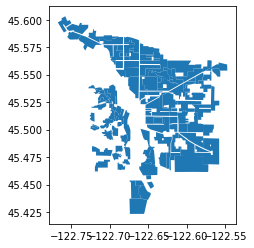

In [85]:
redline.plot();

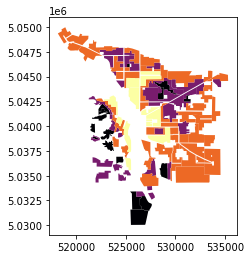

In [97]:
# reprojecting and quick plot
redline_r = redline.to_crs(proj)
# assigning colors

redline_r.plot(column='holc_grade', cmap='inferno');

/srv/conda/envs/notebook/lib/python3.8/site-packages/geopandas/plotting.py:146: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  collection = PatchCollection([PolygonPatch(poly) for poly in geoms], **kwargs)


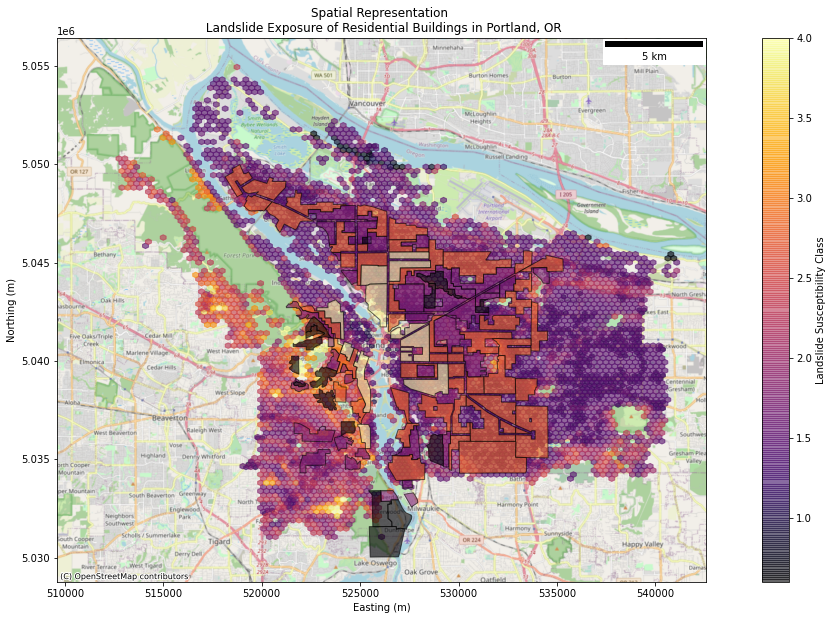

In [105]:
# plot with hexbin
f, ax=plt.subplots(figsize=(20,10))
# n_rp.plot(ax=ax, facecolor='grey', alpha=0.5, edgecolor='k', lw=1)

# hexbin points
hb_mul = ax.hexbin(x_mul, y_mul, C=b_mulfam_r['ls_rio_sample'], alpha=0.6, gridsize=100, mincnt=1, cmap='inferno')
hb_sin = ax.hexbin(x_sin, y_sin, C=b_sinfam_r['ls_rio_sample'], alpha=0.6, gridsize=100, mincnt=1, cmap='inferno')

# Adding redline mapping
redline_r.plot(ax=ax, column='holc_grade', cmap='inferno', alpha=0.6, edgecolor='k', Lw=1)

ax.set_title('Spatial Representation \n Landslide Exposure of Residential Buildings in Portland, OR')
ax.set_xlabel('Easting (m)')
ax.set_ylabel('Northing (m)')
ax.add_artist(ScaleBar(1.0))
cd = f.colorbar(hb_mul, ax=ax)
cd.set_label('Landslide Susceptibility Class')

# Add basemap
ctx.add_basemap(ax=ax, crs=n_rp.crs, source=ctx.providers.OpenStreetMap.Mapnik);

## Conclusions
### Landslide Susceptibility for residential buildings in Portland Oregon: 
* 74% of residential buildings fall under low susceptibility class
* 22% of residential buildings fall under Moderate susceptibility class
* 3% of residential buildings fall under High susceptibility class
* 1% of residential buildings fall under Very High susceptibility class
* The section with the highest exposure to landslide susceptibility is Southwest Portland

### About methodology
* UTM Zone 10 projection is suitable for this analysis
* Using rio sample for the centroid of each building polygon do not differ too much in LS classes from other methods such as polygon centroid-buffer or multipolygon shapes statistics

### Further Research
* Statistics based on Building types
* Using probability of landslide over time
* Economic impacts (Annual Loss)